# Classification: Pothole vs. Non-pothole

Description: Classifying 2-second trip intervals as potholes vs. non-potholes using accelerometer and gyroscope data.

In [29]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

### Load and combine all trip data files

In [30]:
numTrips = 5
tripDir = 'data/Pothole_Non_Pothole/'
allTripsDF = pd.DataFrame()


for tripIndex in xrange(1, numTrips+1):
    tripFilePath = tripDir + "trip%s_intervals.csv" % tripIndex
    tripDF = pd.read_csv(tripFilePath)
    allTripsDF = allTripsDF.append(tripDF)
    
# Some data cleaning
allTripsDF.drop('Unnamed: 0', axis=1, inplace=True)
allTripsDF.dropna(inplace=True)
allTripsDF.reset_index(drop=True, inplace=True)

print allTripsDF.shape
allTripsDF.head()

(987, 27)


,meanSpeed,sdSpeed,maxAccelX,maxAccelY,maxAccelZ,maxGyroX,maxGyroY,maxGyroZ,minAccelX,minAccelY,...,meanGyroX,meanGyroY,meanGyroZ,sdAccelX,sdAccelY,sdAccelZ,sdGyroX,sdGyroY,sdGyroZ,pothole
0,0.041,0.129653,0.053787,-0.936584,0.295486,-0.007371,0.019259,0.007240,0.016998,-0.963852,...,-0.020783,-0.001779,0.000218,0.011710,0.009103,0.040247,0.010819,0.008888,0.003437,False
1,1.364,1.024057,0.120621,-0.875656,0.398834,0.022393,0.006554,0.033050,0.026840,-0.943787,...,-0.022780,-0.018999,-0.003276,0.031252,0.022495,0.028734,0.020178,0.019851,0.014961,False
2,4.436,1.351158,0.120605,-0.906296,0.404266,-0.010554,0.051599,0.018975,0.033325,-0.988800,...,-0.032363,-0.011066,-0.006807,0.024182,0.022507,0.057296,0.022679,0.024039,0.016592,False
3,7.060,0.575326,0.115387,-0.893860,0.379074,0.067697,-0.015656,0.061929,-0.036392,-0.986603,...,-0.038749,-0.074418,0.020480,0.047576,0.036484,0.068351,0.095503,0.052869,0.028209,False
4,9.149,0.864902,0.127914,-0.914444,0.357315,0.031195,0.094832,0.056660,0.008118,-1.018906,...,-0.006386,-0.015274,0.014688,0.038033,0.032032,0.052048,0.022819,0.048195,0.032339,False


### Setup Features and Labels

In [31]:
y = allTripsDF['pothole'].astype(int)
X = allTripsDF[['meanSpeed', 'sdSpeed', 'maxAccelX', 'maxAccelY', 'maxAccelZ', 'maxGyroX', 
                'maxGyroY', 'maxGyroZ', 'minAccelX', 'minAccelY', 'minAccelZ', 'minGyroX', 
                'minGyroY', 'minGyroZ', 'meanAccelX', 'meanAccelY', 'meanAccelZ', 
                'meanGyroX', 'meanGyroY', 'meanGyroZ', 'sdAccelX', 'sdAccelY', 'sdAccelZ', 
                'sdGyroX', 'sdGyroY', 'sdGyroZ']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Imbalance of Classes

There's way more non-pothole intervals than pothole intervals! Need to keep this in mind.

In [32]:
pd.value_counts(y)

0    908
1     79
Name: pothole, dtype: int64

## Classification: Baseline Model

This is the same as predicting the majority class for every instance. Will serve as a baseline for accuracy/precision/recall.

In [33]:
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print "Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Accuracy: 0.898773006135

Classification Report:
             precision    recall  f1-score   support

          0       0.90      1.00      0.95       293
          1       0.00      0.00      0.00        33

avg / total       0.81      0.90      0.85       326


Confusion matrix:


array([[293,   0],
       [ 33,   0]])

## Classification: SVM

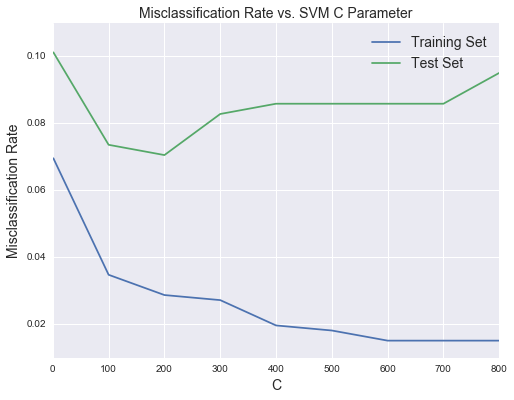

In [7]:
Cs = [1, 100, 200, 300, 400, 500, 600, 700, 800]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for c in Cs:
    clf = SVC(C=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. SVM C Parameter', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

### Evaluation: SVM

In [8]:
# Final SVM Classifier
clf = SVC(C=200)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print "Final Test Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Final Test Accuracy: 0.929447852761

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       293
          1       0.86      0.36      0.51        33

avg / total       0.93      0.93      0.92       326


Confusion matrix:


array([[291,   2],
       [ 21,  12]])

## Classification: Logistic Regression

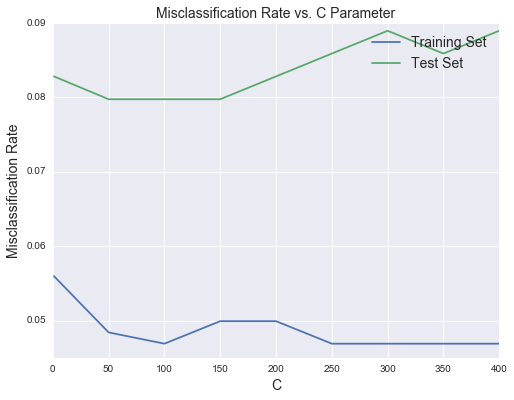

In [9]:
Cs = [1, 50, 100, 150, 200, 250, 300, 350, 400]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for c in Cs:
    clf = LogisticRegression(C=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. C Parameter', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

### Evaluation: Logistic Regression

In [10]:
# Final Logistic Regression Classifier
clf = LogisticRegression(C=100)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print "Final Test Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Final Test Accuracy: 0.920245398773

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.98      0.96       293
          1       0.68      0.39      0.50        33

avg / total       0.91      0.92      0.91       326


Confusion matrix:


array([[287,   6],
       [ 20,  13]])

## Classification: Random Forest

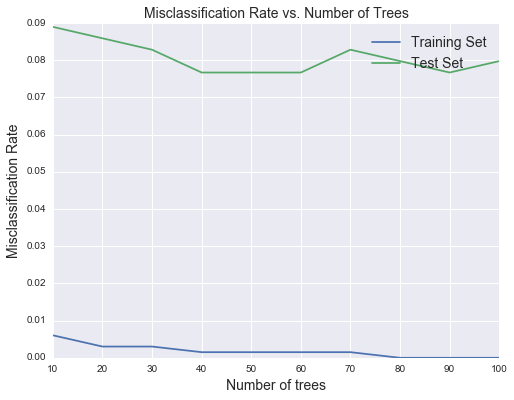

In [11]:
numTrees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for n in numTrees:
    clf = RandomForestClassifier(n_estimators=n, random_state=0)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(numTrees, trainMisclassRate, label="Training Set")
plt.plot(numTrees, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. Number of Trees', fontsize=14)
plt.xlabel('Number of trees', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

### Evaluation: Random Forest

In [12]:
# Final Random Forest Classifier
clf = RandomForestClassifier(n_estimators=50, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print "Final Test Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Final Test Accuracy: 0.923312883436

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       293
          1       0.75      0.36      0.49        33

avg / total       0.91      0.92      0.91       326


Confusion matrix:


array([[289,   4],
       [ 21,  12]])

## Classification: Gradient Boosting

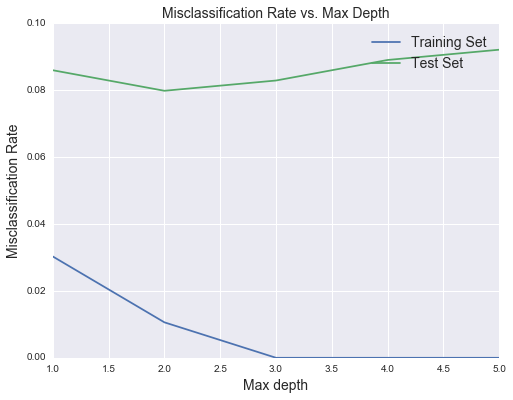

In [13]:
depths = [1, 2, 3, 4, 5]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for d in depths:
    clf = GradientBoostingClassifier(max_depth=d, random_state=0)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(depths, trainMisclassRate, label="Training Set")
plt.plot(depths, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. Max Depth', fontsize=14)
plt.xlabel('Max depth', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

### Evaluation: Gradient Boosting

In [14]:
# Final Gradient Boosting Classifier
clf = GradientBoostingClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print "Final Test Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Final Test Accuracy: 0.920245398773

Classification Report:
             precision    recall  f1-score   support

          0       0.94      0.97      0.96       293
          1       0.65      0.45      0.54        33

avg / total       0.91      0.92      0.91       326


Confusion matrix:


array([[285,   8],
       [ 18,  15]])

## Classification: K-nearest Neighbors

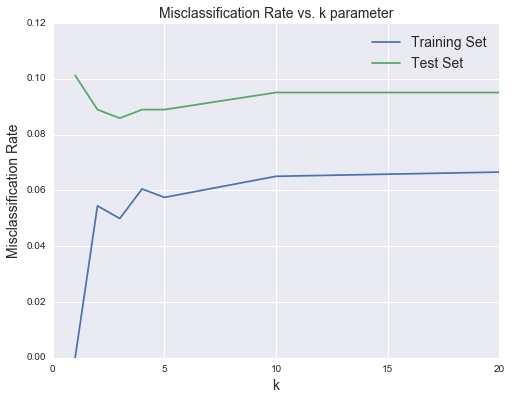

In [15]:
Ks = [1,2,3,4,5,10,20]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for k in Ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Ks, trainMisclassRate, label="Training Set")
plt.plot(Ks, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. k parameter', fontsize=14)
plt.xlabel('k', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

### Evaluation: KNN

In [16]:
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print "Final Test Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Final Test Accuracy: 0.911042944785

Classification Report:
             precision    recall  f1-score   support

          0       0.91      1.00      0.95       293
          1       1.00      0.12      0.22        33

avg / total       0.92      0.91      0.88       326


Confusion matrix:


array([[293,   0],
       [ 29,   4]])

## Final Model: SVM

The SVM model performed the best in terms of accuracy, but we can try to optimize its precision-recall tradeoff. We want to balance correctly flagging potholes (precision) and detecting all the true potholes (recall).

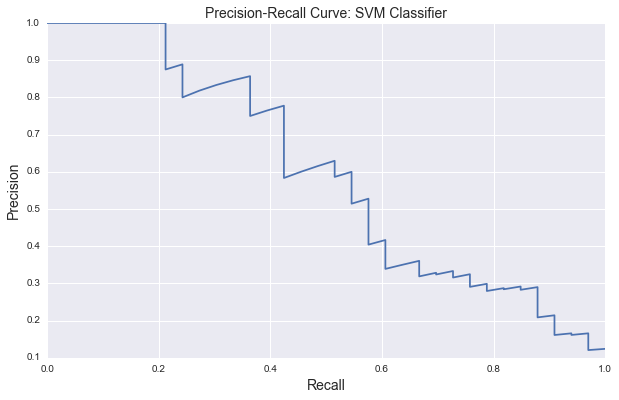

In [41]:
plt.figure(figsize=(10,6))
clf = SVC(C=200)
clf.fit(X_train,y_train)
y_scores = clf.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
plt.plot(recall, precision)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve: SVM Classifier', fontsize=14)
plt.show()

From this precision-recall curve, we get all the combinations of precision and recall values for different thresholds on the SVM decision function. We choose a threshold that gives us a precision of 0.78 and a recall of 0.42. This seems like a good tradeoff.

In [80]:
selectedTradeoffIndex = np.intersect1d(np.where(precision >= 0.75), np.where(precision <= 0.8))[0]
selectedThreshold = thresholds[selectedTradeoffIndex]
print "Precision", "%0.2f" % precision[selectedTradeoffIndex]
print "Recall", "%0.2f" % recall[selectedTradeoffIndex]
print "Decision function threshold", "%0.2f" % thresholds[selectedTradeoffIndex]

Precision 0.78
Recall 0.42
Decision function threshold -0.21


Now, we can classify points using this selected threshold to give us the desired precision and recall.

In [84]:
y_pred = (y_scores >= selectedThreshold).astype(int)
accuracy = np.mean(y_pred==y_test)
print "Final Test Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Final Test Accuracy: 0.929447852761

Classification Report:
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       293
          1       0.78      0.42      0.55        33

avg / total       0.92      0.93      0.92       326


Confusion matrix:


array([[289,   4],
       [ 19,  14]])

Compared to our initial SVM model, our revised model still retains an accuracy of 92.9%. But now, it makes a better tradeoff between precision and recall, which brings up its f1-score.

Here, a precision of 0.78 means that when our model classifies an interval as having potholes, 78% of those intervals actually have potholes. 

A recall of 0.42 means that our model correctly classifies 42% of the true pothole intervals.